# Example 3: MPD-TMC polyamides
Another polyamide example, but with branchable (i.e. non-linear) monomers 

## Output config

In [1]:
import logging
logging.basicConfig(level=logging.INFO, force=True)

from rdkit.Chem.Draw import MolsToGridImage
from polymerist.rdutils.rdkdraw import set_rdkdraw_size, disable_substruct_highlights, enable_kekulized_drawing


# Molecule drawing settings
MOL_IMG_WIDTH  : int = 400
MOL_IMG_HEIGHT : int = 300
MOL_IMG_SIZE = (MOL_IMG_WIDTH, MOL_IMG_HEIGHT)

enable_kekulized_drawing()
disable_substruct_highlights()
set_rdkdraw_size(MOL_IMG_WIDTH, MOL_IMG_WIDTH / MOL_IMG_HEIGHT)

INFO:rdkit:Enabling RDKit 2023.09.6 jupyter extensions
INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


## Define chemically-complete monomer "feedstocks"

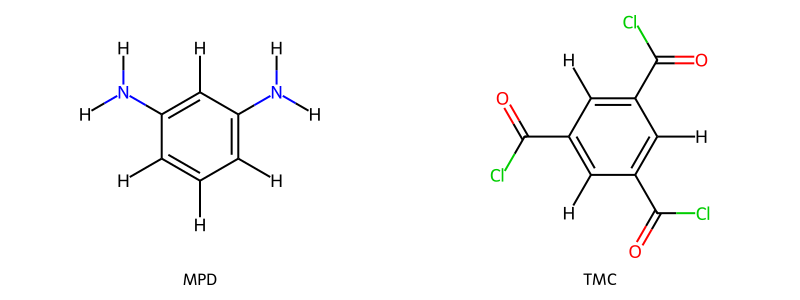

In [2]:
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.rdmolops import SANITIZE_ALL, AROMATICITY_MDL
from polymerist.rdutils.sanitization import explicit_mol_from_SMILES, Smiles


monomer_smiles : dict[str, Smiles] = {
    'MPD' : 'c1ccc(N)cc1N',                        # m-phenylene diamine
    'TMC' : 'c1c(C(=O)Cl)cc(C(=O)Cl)cc1(C(=O)Cl)', # trimesoyl chloride
}
monomers : dict[str, Mol] = {
    name : explicit_mol_from_SMILES(smiles, sanitize_ops=SANITIZE_ALL, aromaticity_model=AROMATICITY_MDL)
    for name, smiles in monomer_smiles.items()
}

MolsToGridImage(monomers.values(), molsPerRow=len(monomers), subImgSize=MOL_IMG_SIZE, legends=list(monomers.keys()))

## Enumerate all possible repeat unit fragments from monomers and reaction template

### Load reaction

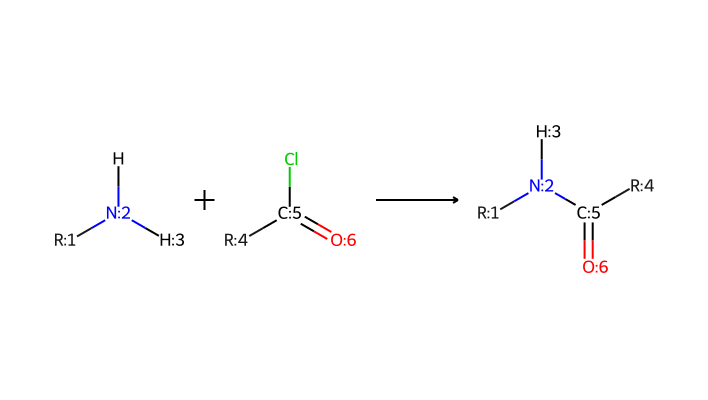

In [3]:
from pathlib import Path
from polymerist.rdutils.reactions import AnnotatedReaction


rxn_file = Path('rxn_demo_files/rxns/amide-acyl chloride condensation.rxn')
if rxn_file.exists():
    # load the polyamide condensation we defined in the nylon demo
    rxn = AnnotatedReaction.from_rxnfile(rxn_file) 
else:
    # load reaction from SMARTs if you never bothered to run the nylon demo :P
    rxn = AnnotatedReaction.from_smarts(
        '[*:1]-[N:2](-[#1:3])-[#1].[*:4]-[C:5](=[O:6])-Cl>>[*:1]-[N:2](-[#1:3])-[C:5](-[*:4])=[O:6]'
    ) 
display(rxn)

### Perform fragment enumeration

INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 1 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 2 new fragments formable after at least 1 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 2 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 2 new fragments formable after at least 2 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 3 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 1 new fragments formable after at least 3 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 4 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 0 new fragments formable after at least 4 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:HALTING NORMALLY: No new reaction fragments discovered requiring 4 reaction step(s) or more


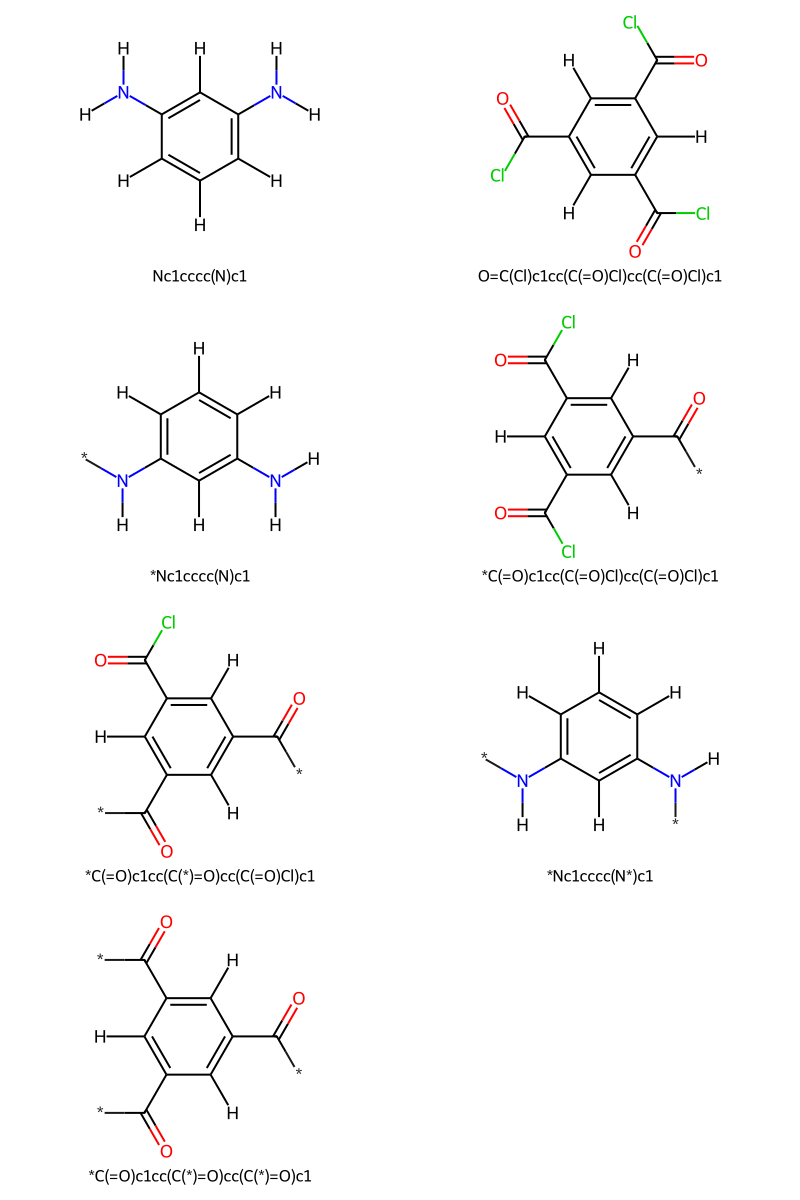

In [ ]:
from polymerist.rdutils.reactions import PolymerizationReactor, CutMinimumCostBondsStrategy

reactor = PolymerizationReactor(
    rxn_schema=rxn,
    fragment_strategy=CutMinimumCostBondsStrategy()
)
fragments = reactor.propagate_pooled(
    monomers.values(),
    sanitize_ops=SANITIZE_ALL,
    aromaticity_model=AROMATICITY_MDL,
    clear_dummy_labels=True,
)
MolsToGridImage(fragments.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=list(fragments.keys()))

### Generate monomer specification-compliant SMARTS with informative names for each non-monomer fragment

In [ ]:
from rdkit.Chem.rdmolfiles import MolFromSmarts
from polymerist.polymers.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_num_ports


named_fragments : dict[str, Smiles] = {}
for canon_smiles, fragment_mol in fragments.items():
    functionality = get_num_ports(fragment_mol)
    if functionality == 0:
        continue # skip fragments with no ports, as these are not useful for polymerization
    
    query_mol = MolFromSmarts(canon_smiles) # important! need to makes SMARTS-based query mol to check for substructure - ports on returned SMILES-based mols are not treated correctly as wild-type atoms
    parent_mol_name = '-'.join(name for name, monomer in monomers.items() if monomer.HasSubstructMatch(query_mol))
    named_fragments[f'{parent_mol_name}_{functionality}-site'] = canon_smiles
    
monogrp = MonomerGroup(named_fragments)
MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=3, subImgSize=MOL_IMG_SIZE, legends=list(monogrp.monomers.keys()))

## Use fragments to assemble a polymer
The builder shipped with polymerist currently supports linear polymer structures; however, the ensemble defined by the fragments generated above  
 could also be used to build and characterize a crosslinker polyamide (e.g. as would occur in a membrane) provided a more robust builder

In [ ]:
from polymerist.polymers.building import build_linear_polymer


# these are for you to configure
n_monomers : int = 100
do_energy_min : bool = False # if enable, will yield more physically-plausible structure, at the cost of slower structure output

monogrp.term_orient = {
    'head' : 'MPD_1-site',
    'tail' : 'TMC_1-site',
}
chain = build_linear_polymer(
    monomers=monogrp,
    sequence='AB',
    n_monomers=n_monomers,
    energy_minimize=do_energy_min, # disabling this will make PDB generation much faster but give less physical structures
)
chain.visualize()

## Export polymer structure files

In [ ]:
from pathlib import Path
from polymerist.genutils.fileutils import assemble_path


polymer_name : str = 'MPD-TMC'
structures_dir = Path('rxn_demo_files/structures') / polymer_name
structures_dir.mkdir(exist_ok=True, parents=True)

### Export to SDFile

In [ ]:
from rdkit.Chem.rdmolfiles import SDWriter
from polymerist.polymers.building import mbmol_to_rdmol


sdf_path = assemble_path(structures_dir, prefix=polymer_name, postfix=f'{n_monomers}mer', extension='sdf')
with sdf_path.open('w') as file:
    writer = SDWriter(file)
    writer.write(mbmol_to_rdmol(chain))

### Export to PDB File

In [ ]:
from polymerist.polymers.building import mbmol_to_openmm_pdb


pdb_path = assemble_path(structures_dir, prefix=polymer_name, postfix=f'{n_monomers}mer', extension='pdb')
pdb_path.parent.mkdir(exist_ok=True, parents=True)
mbmol_to_openmm_pdb(pdb_path, chain)

### Save repeat unit fragments to disc

In [ ]:
fragments_path = assemble_path('rxn_demo_files/fragments', prefix=polymer_name, extension='json')
fragments_path.parent.mkdir(exist_ok=True, parents=True)
monogrp.to_file(fragments_path)